# Review words

In [1]:
using DataFrames
using Arrow
using Printf
using StatsBase: mean, sample
using Random
using Revise
using Plots
using Unicode

In [2]:
using TokenizersLite

In [3]:
pattern = r"[A-Za-z][A-Za-z]+\b"

r"[A-Za-z][A-Za-z]+\b"

## Load data

In [4]:
path = "path\\to\\amazon_reviews_multi\\en\\1.0.0\\"
file_train = "amazon_reviews_multi-train.arrow"
file_test = "amazon_reviews_multi-test.arrow" ;

In [5]:
checksum = readdir(path)[1]
filepath = joinpath(path, checksum, file_train)
df = DataFrame(Arrow.Table(filepath))

checksum = readdir(path)[1]
filepath = joinpath(path, checksum, file_test)
df_test = DataFrame(Arrow.Table(filepath));

In [6]:
nrow(df)

200000

## Tokenizers

In [7]:
function clean(s::AbstractString)
    s = lowercase(s)
    s = Unicode.normalize(s, :NFD)
    s = replace(s, r"['`’\u200d\p{M}]" => "") # contractions, zero width joiner and marks from normalization
    s = replace(s, r"\n" => " ")
end

function preprocess(document; pattern = r"[A-Za-z][A-Za-z]+\b", max_length::Union{Nothing, Int}=nothing)
    document = clean(document)
    words = map(m->string(m.match), eachmatch(pattern, document))
    words
end

preprocess (generic function with 1 method)

In [8]:
directory = "../vocab\\bpe"
path_rules = joinpath(directory, "amazon_reviews_train_en_rules.txt")
bpe = load_bpe(path_rules, startsym="⋅")

BytePairEncoder{String}(length(rules)=8000, length(cache)=0, unksym=[UNK], startsym=⋅, symbols=["##a", "##b", "##c", "##d", "##e", "##f", "##g", "##h", "##i", "##j", "##k", "##l", "##m", "##n", "##o", "##p", "##q", "##r", "##s", "##t", "##u", "##v", "##w", "##x", "##y", "##z", "⋅a", "⋅b", "⋅c", "⋅d", "⋅e", "⋅f", "⋅g", "⋅h", "⋅i", "⋅j", "⋅k", "⋅l", "⋅m", "⋅n", "⋅o", "⋅p", "⋅q", "⋅r", "⋅s", "⋅t", "⋅u", "⋅v", "⋅w", "⋅x", "⋅y", "⋅z", ",", ".", "?", "!", ":", ";", "\$", "€", "£", "&"])

In [9]:
directory = "../vocab\\affixes"
path_vocab = joinpath(directory, "amazon_reviews_train_en_vocab.txt")
affixer = load_affix_tokenizer(path_vocab)

AffixTokenizer(length(vocab)=7179, prefixes=["un", "in"], suffixes=["s", "ed", "ing", "ly", "er", "es", "ers", "al", "ally", "ion", "en", "able", "ably", "less", "ies", "ation", "ty", "est", "ier", "ive", "ment", "ity", "ness", "ful", "or", "age", "ie", "ish", "ible", "ery", "ingly", "ant", "ical", "ance", "ative", "ous", "ties", "ary", "ist", "ated", "ial", "hood", "ify", "itive", "ition", "ise", "eous", "tion", "ious", "ate"])

In [10]:
idx = 100
println(idx)
document = df[idx, "review_body"]
println(document)
words = preprocess(document, pattern=pattern)
println(join(words, "|"))
tokens = bpe(words)
println(join(tokens, "|"))
tokens = affixer(words)
println(join(tokens, "|"))

100
I bought these bottles with the intention of mixing essential oils in them. The spray hardly works and they leak frequently. Would not recommend for use with essential oils.
bought|these|bottles|with|the|intention|of|mixing|essential|oils|in|them|the|spray|hardly|works|and|they|leak|frequently|would|not|recommend|for|use|with|essential|oils
⋅bought|⋅these|⋅bottles|⋅with|⋅the|⋅intent|##ion|⋅of|⋅mixing|⋅essential|⋅oils|⋅in|⋅them|⋅the|⋅spray|⋅hardly|⋅works|⋅and|⋅they|⋅leak|⋅frequently|⋅would|⋅not|⋅recommend|⋅for|⋅use|⋅with|⋅essential|⋅oils
bought|these|bottle|-s|with|the|intention|of|mix|-ing|essential|oil|-s|in|them|the|spray|hard|-ly|work|-s|and|they|leak|frequent|-ly|would|not|recommend|for|use|with|essential|oil|-s


## Data exploration

In [11]:
names(df)

8-element Vector{String}:
 "review_id"
 "product_id"
 "reviewer_id"
 "stars"
 "review_body"
 "review_title"
 "language"
 "product_category"

In [12]:
first(df, 5)

,review_id,product_id,reviewer_id,stars,review_body
,String?,String?,String?,Int32?,String?
1,en_0964290,product_en_0740675,reviewer_en_0342986,1,"Arrived broken. Manufacturer defect. Two of the legs of the base were not completely formed, so there was no way to insert the casters. I unpackaged the entire chair and hardware before noticing this. So, I'll spend twice the amount of time boxing up the whole useless thing and send it back with a 1-star review of part of a chair I never got to sit in. I will go so far as to include a picture of what their injection molding and quality assurance process missed though. I will be hesitant to buy again. It makes me wonder if there aren't missing structures and supports that don't impede the assembly process."
2,en_0690095,product_en_0440378,reviewer_en_0133349,1,the cabinet dot were all detached from backing... got me
3,en_0311558,product_en_0399702,reviewer_en_0152034,1,I received my first order of this product and it was broke so I ordered it again. The second one was broke in more places than the first. I can't blame the shipping process as it's shrink wrapped and boxed.
4,en_0044972,product_en_0444063,reviewer_en_0656967,1,"This product is a piece of shit. Do not buy. Doesn't work, and then I try to call for customer support, it won't take my number. Fucking rip off!"
5,en_0784379,product_en_0139353,reviewer_en_0757638,1,went through 3 in one day doesn't fit correct and couldn't get bubbles out (better without)


In [13]:
labels = df[:, "stars"];

In [14]:
n = length(labels)
nshow = 2
for stars in 1:5
    println(stars)
    idxs  = (1:n)[labels .== stars] 
    for idx in sample(idxs, nshow)
        println("$(idx):", df[idx, "review_body"])
    end
end

1
39689:This thing is too hard. It hurt just as bad as whatI was trying to fix!
19921:Wow first off the wefts are thick but hair is thin and stringy there are actually short pieces within the bundles like it was cut the dye job is horrible the hair is over processed and has a lot of split ends I’m glad the hair was cheap I guess you get what you pay for
2
40405:I wanted to love this. But it's incredibly light weight and has some weird lumps in it when I make my bed. Like it doesn't lay correctly out flat.
71751:The shirt fits nicely but I ordered it because I didn't want a cotton shirt that would have to be ironed everytime it was washed. It says that it is 95% Rayon and 5% Spandex but it is 100% cotton and wrinkles horribly.
3
113742:Size a half up, I’m a 9.5 I definitely needed to return and purchase a 10
115520:Bigger than I expected.
4
132868:It was pretty simple to apply. But I messed up and removed 1 and I had not even applied any pressure. It took me awhile to remove and it left

In [15]:
languages = unique(df[:, :language])

1-element Vector{Union{Missing, String}}:
 "en"

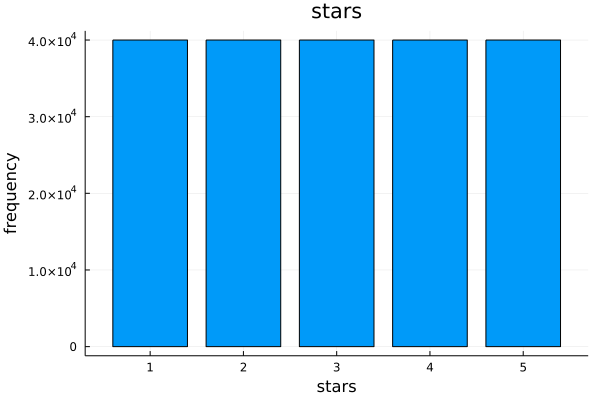

In [16]:
x = 1:5
y = [sum(labels .== l) for l in x]
bar(x, y, xlabel="stars", ylabel="frequency", title="stars", label="")

In [17]:
products = unique(df[!, :product_category])

31-element Vector{Union{Missing, String}}:
 "furniture"
 "home_improvement"
 "home"
 "wireless"
 "pc"
 "industrial_supplies"
 "kitchen"
 "apparel"
 "automotive"
 "camera"
 "lawn_and_garden"
 "watch"
 "beauty"
 ⋮
 "jewelry"
 "sports"
 "other"
 "baby_product"
 "video_games"
 "office_product"
 "grocery"
 "digital_video_download"
 "luggage"
 "shoes"
 "musical_instruments"
 "personal_care_appliances"

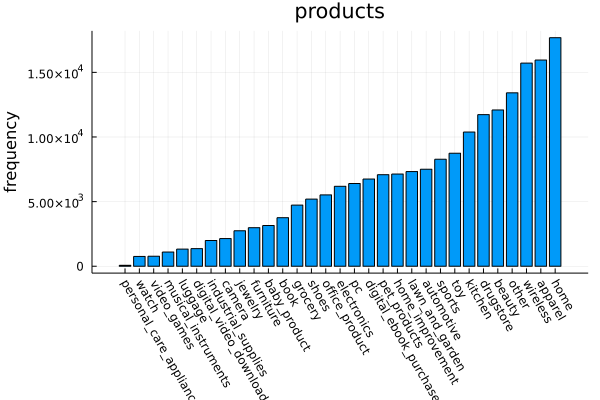

In [18]:
x = 1:length(products)
y = [sum(df[!, :product_category] .== p) for p in products]
idxs = sortperm(y)
bar(x, y[idxs], 
    title="products", xlabel="product categories", ylabel="frequency", label="", 
    xrotation=-60, xticks=(x, products[idxs])
)

### lengths

In [19]:
transform!(df, :review_title =>  ByRow(s -> length(s)) => :review_title_length);
transform!(df, :review_title =>  ByRow(s -> length(findall(pattern, s))) => :review_title_word_count);

In [20]:
transform!(df, :review_body =>  ByRow(s -> length(s)) => :review_length);
transform!(df, :review_body =>  ByRow(s -> length(findall(pattern, s))) => :review_word_count);

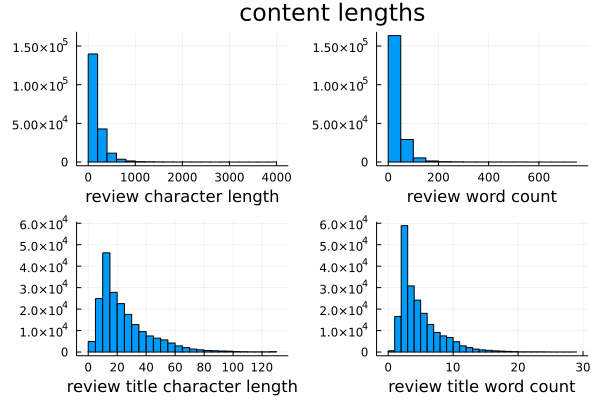

In [21]:
p1 = histogram(df[!, :review_length], nbins=30, label="", xlabel="review character length")
p2 = histogram(df[!, :review_word_count], nbins=30,  label="", xlabel="review word count")
p3 = histogram(df[!, :review_title_length], nbins=30, label="", xlabel="review title character length")
p4 = histogram(df[!, :review_title_word_count], nbins=30,  label="", xlabel="review title word count")
plot(p1, p2, p3, p4, labyout=grid(2, 2), link=:y, plot_title="content lengths")

### tokenizers

In [22]:
function encode_bpe(document)
    bpe(preprocess(document, pattern=pattern))
end
function encode_affixer(document)
    affixer(preprocess(document, pattern=pattern))
end
@time transform!(df, :review_body =>  ByRow(s -> length(encode_bpe(s))) => :bpe_length); # takes about 30 seconds
@time transform!(df, :review_body =>  ByRow(s -> length(encode_affixer(s))) => :affixer_length); # takes about 10 seconds

 60.579259 seconds (654.47 M allocations: 20.559 GiB, 8.54% gc time, 0.65% compilation time)
 19.739316 seconds (140.26 M allocations: 5.529 GiB, 7.16% gc time, 0.74% compilation time)


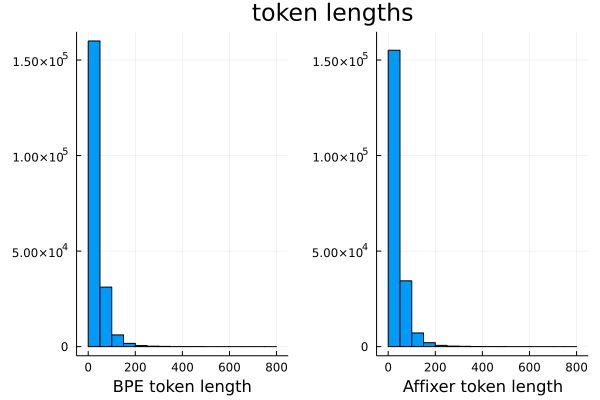

In [23]:
p1 = histogram(df[!, :bpe_length], nbins=30, label="", xlabel="BPE token length")
p2 = histogram(df[!, :affixer_length], nbins=30,  label="", xlabel="Affixer token length")
plot(p1, p2, labyout=grid(1, 2), link=:y, plot_title="token lengths")

In [24]:
@show mean(df[:, :bpe_length])
for threshold in [25, 50, 75, 100] 
    frac = count(x->x<threshold, df[:, :bpe_length]) / nrow(df)
    @printf "%3d - %.4f\n" threshold frac
end

mean(df[:, :bpe_length]) = 33.6101
 25 - 0.5184
 50 - 0.7998
 75 - 0.9097
100 - 0.9556


In [25]:
mean(df[:, :affixer_length])
for threshold in [25, 50, 75, 100] 
    frac = count(x->x<threshold, df[:, :affixer_length]) / nrow(df)
    @printf "%3d - %.4f\n" threshold frac
end

 25 - 0.4850
 50 - 0.7756
 75 - 0.8954
100 - 0.9478
